<img src="Imagenes/entreno.jpeg" alt="Imagen creada con inteligencia artificial y editada con Microsoft Paint" style="border-radius: 15px; width: 80%;">

*Imagen creada con inteligencia artificial*

## **BIBLIOTECAS USADAS:**

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math 
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from keras.models import save_model
from keras.models import load_model
import os 
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

## **CARGADO DE DATOS:**

In [2]:
df = pd.read_csv('datos/fer2013/fer2013_blc.csv')

>**Cargaremos el dataset balanceado, el cual se balanceó con técnicas de data augmentation.**

## **DIVISIÓN EN ENTRENAMIENTO, VALIDACIÓN Y PRUEBAS:**

In [3]:
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PrivateTest']
test_df = df[df['Usage'] == 'PublicTest']

>**No usaremos "train_test_split" de "sklearn", sino que utilizaremos la columna "Usage", la cual indica uno de los tres usos para cada línea del dataframe.**

## **PREPARACIÓN DE LOS DATOS:**

In [4]:
def string_to_image_array(string):
    pixels = np.array(string.split(), dtype=np.float32)
    return pixels.reshape((48, 48, 1))  
  
def prepare_data(df):
    X_pixels = np.array([string_to_image_array(pixels) for pixels in df['pixels']])
    X_pixels = X_pixels.astype('float32') / 255.0
    y = df['emotion']
    return X_pixels, y  

#Llamadas: 

X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)
X_test, y_test = prepare_data(test_df)

>**Con la función "string_to_image_array" se convierte una cadena de números separados por espacios (como en nuestro dataset) en un array unidimensional de 48x48.**
>  
>**Con la función "prepare_data", aplicamos la función anterior a la columna "pixels" de los dataframes y normalizamos los valores (dividiéndolos entre 255, que es el valor más alto del rango de color en este caso), para ello, desde esta, llamamos a la fincion anterior**
>  
>**Luego, con las llamadas, aplicamos estas funciones a cada una de las 3 partes en las que hemos dividido el dataframe en la celda anterior.**

## **AUMENTACIÓN DE DATOS PARA EL CONJUNTO DE PRUEBAS:**

In [5]:
datagen = ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,horizontal_flip=True)
datagen.fit(X_train)


> **Con esto aplicamos nuevos cambios (además de los ya aplicados) para que el dataset de entrenamiento tenga mayor cantidad de fotografias.**
>  
>**En un principio, se sospechó que usar “horizontal flip” pudiera traer consigo algo de sobreajuste, dado que fue el primer método de aumentación de datos usado en ambos datasets. En los modelos que se han ido probando, se observó que en algunos no aportaba nada; en otros, se observó que provocaba algo de sobreajuste. En este modelo, aumentó poco más de un punto en precisión, sin observarse cambios en la pérdida ni sobreajuste, por lo que se decidió también usar "horizontal flip" en el aumento de datos “datagen”.**  



## **DEFINICION DEL MODELO CNN**

In [6]:
model_cnn = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.00038558)),
    Dropout(0.1),

    Dense(128, activation='relu', kernel_regularizer=l2(0.00031289)),
    Dropout(0.25),

    Dense(7, activation='softmax')
])

C:\Users\pepea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


> **Este modelo es una red neuronal convolucional diseñada para clasificar imágenes en 7 categorías. Utiliza varias capas que identifican características importantes en las imágenes, como bordes y texturas. Luego, estas características se combinan y procesan en capas densas para hacer la clasificación final. El modelo también incluye técnicas para mejorar el rendimiento y evitar el sobreajuste, como la normalización, la regularización y la desactivación temporal de algunas conexiones.**  
>  
>**Los hiperparámetros de l2 y dropout se han elegido gracias a pruebas con un modelo usando una herramienta de 'Hyperparameter Tuner', específicamente 'Hyperband' de 'keras', que busca los valores óptimos para los hiperparámetros. Aunque este proceso no es eficiente en cuanto al tiempo —en más de 20 horas de entrenamiento continuo no había terminado ni la mitad del proceso— fue suficiente para identificar valores adecuados para estos hiperparámetros.**  
>  
>>**"CNN" significa "red neuronal convolucional".**

## **COMPILACIÓN DEL MODELO:**

In [7]:
model_cnn.compile(loss='sparse_categorical_crossentropy',  
              optimizer=Adam(learning_rate=0.000012),  
              metrics=['accuracy'])  

> **En Adam, el learning rate por defecto es 0.001. Hemos especificado este valor porque, tras experimentar con diversos modelos, hemos visto que funciona bien.**
**La tasa de aprendizaje controla la magnitud de los ajustes que se realizan a los pesos del modelo durante el proceso de entrenamiento.**
>>una tasa de aprendizaje baja proporciona actualizaciones más precisas y estables de los pesos del modelo, mejorando la precisión y reduciendo el riesgo de sobreajuste al permitir una convergencia más suave hacia el mínimo del error. como desventaja tenemos que requiere de mas tiempo de mayor capacidad computacional (hablando en plata, "mejor ordenador")
>  
>**'sparse_categorical_crossentropy' se utiliza típicamente en problemas de clasificación donde las etiquetas son números enteros, es decir, cuando solo puede darse una clase y se debe elegir una opción, como en nuestro caso, donde se elige entre una de las 7 expresiones.**
>  
>**La métrica es accuracy porque es la que queremos mejorar.**  
>  


## **RESUMEN DEL MODELO**

In [8]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,718,791 (6.56 MB)

 Trainable params: 1,716,871 (6.55 MB)

 Non-trainable params: 1,920 (7.50 KB)

## **DEFINICIÓN DE CALLBACKS**

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=2, min_lr=0.000003796875, verbose=1, initial_lr=0.000009)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 


>**"ReduceLROnPlateau" reduce la tasa de aprendizaje (learning_rate) si los valores de la pérdida en el conjunto de validación (val_loss) dejan de mejorar o empeoran durante un número determinado de épocas (especificado por patience, 2 epocas en nuestro caso). Factor indica por cuanto se irá reduciendo el learning rate. Monitorea "val_loss" por que así lo hemos decidido en "monitor=val_loss"**  
>  
>**EarlyStopping se encarga de detener el entrenamiento cuando la métrica fijada por 'monitor' (en nuestro caso, 'val_accuracy') deja de mejorar durante tantas épocas como indica patience. "restore_best_weights=True" hace que el modelo "se quede" con los pesos de la época que dio los mejores resultados para la métrica monitoreada.**  
>    
>  **⚠️⚠️  NO SOLO BUSCAMOS BUENOS RESULTADOS PARA PRESICIÓN Y PERDIDA BUSCAMOS QUE EL MODELO GENERALICE BIEN, 'EL PROGRAMA' SE PUEDE ENFRENTAR A FOTOGRAFIAS EN DIVERSAS CONDICIONES Y TIENE QUE TENER LA MISMA ESACTITUD CON ESTAS QUE CON AQUELLAS CON LAS QUE SE ENTRENÓ. POR ESO LA PACIENCIA ES TAN BAJA**


## **ENTRENAMIENTO DEL MODELO**

In [10]:
history = model_cnn.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=45,  
                    verbose=1,
                    validation_data=(X_val, y_val),  
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/45


C:\Users\pepea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


790/790 ━━━━━━━━━━━━━━━━━━━━ 180s 221ms/step - accuracy: 0.1805 - loss: 2.5040 - val_accuracy: 0.2792 - val_loss: 1.9997 - learning_rate: 1.2000e-05
Epoch 2/45
790/790 ━━━━━━━━━━━━━━━━━━━━ 174s 220ms/step - accuracy: 0.2528 - loss: 2.0734 - val_accuracy: 0.3233 - val_loss: 1.9142 - learning_rate: 1.2000e-05
Epoch 3/45
790/790 ━━━━━━━━━━━━━━━━━━━━ 174s 220ms/step - accuracy: 0.2871 - loss: 1.9899 - val_accuracy: 0.3636 - val_loss: 1.8382 - learning_rate: 1.2000e-05
Epoch 4/45
790/790 ━━━━━━━━━━━━━━━━━━━━ 174s 220ms/step - accuracy: 0.3236 - loss: 1.9247 - val_accuracy: 0.3863 - val_loss: 1.7772 - learning_rate: 1.2000e-05
Epoch 5/45
790/790 ━━━━━━━━━━━━━━━━━━━━ 173s 218ms/step - accuracy: 0.3483 - loss: 1.8679 - val_accuracy: 0.4195 - val_loss: 1.7167 - learning_rate: 1.2000e-05
Epoch 6/45
790/790 ━━━━━━━━━━━━━━━━━━━━ 165s 209ms/step - accuracy: 0.3731 - loss: 1.8149 - val_accuracy: 0.4383 - val_loss: 1.6608 - learning_rate: 1.2000e-05
Epoch 7/45
790/790 ━━━━━━━━━━━━━━━━━━━━ 166s 210ms/

> **El tiempo de entrenamiento de este modelo, con estos datos e hiperparámetros, fue de 2 horas y 10 minutos. Esto dependerá de las características del ordenador donde se corra. Puedes ver las características del ordenador en el Jupyter Notebook 'instrucciones'.**

>**Para el entrenamiento usaremos el dataset reservado para tal fin. El tamaño de lotes, 'batch_size', se ha elegido por experimentación, probando diferentes valores, y probamos diferentes épocas hasta que vimos que los valores dejaban de mejorar. La validación será con la parte de los datos reservada para tal fin.**  
>  


## **EVALUACIÓN DEL MODELO CONTRA EL CONJUNTO DE PRUEBAS**

In [11]:
loss, accuracy = model_cnn.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida en el conjunto de prueba:     {loss:.4f}')
print(f'Presición en el conjunto de prueba:   {accuracy*100:.2f}%')

Pérdida en el conjunto de prueba:     1.3674
Presición en el conjunto de prueba:   56.01%


**RESULTADOS:**  
  
Pérdida en el conjunto de prueba:     1.3674  
Presición en el conjunto de prueba:   56.01%  

*Al correr el mismo modelo con los mismos datos, los resultados pueden variar ligeramente debido a la aleatoriedad de algunos cálculos.*

> **Una vez terminado el entrenamiento del modelo, es importante saber qué tan bien (o mal) funciona el modelo. Durante el proceso de entrenamiento hemos ido viendo cómo mejoraban las métricas con respecto al conjunto de datos de validación. Es posible que el modelo se haya aprendido un poco el dataset de validación, por lo que es importante conocer las metricas principales (precisión y pérdida en nuestro caso) en un conjunto de datos hasta ahora no visto. Por eso, veremos estas métricas en el conjunto de pruebas (test).**

## **ESTUDIO DE LA MEJORA DEL MODELO A LO LARGO DE LAS EPOCHS**

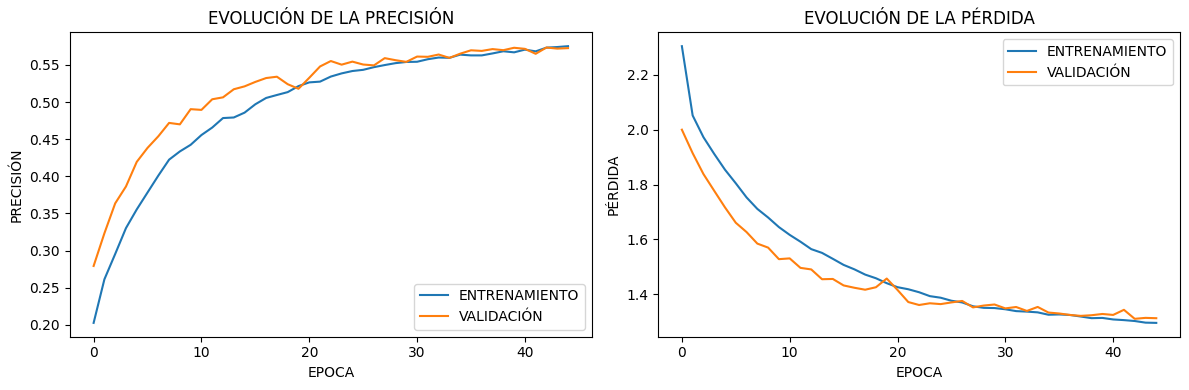

In [12]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráficos de precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='ENTRENAMIENTO')
plt.plot(val_accuracy, label='VALIDACIÓN')
plt.xlabel('EPOCA')
plt.ylabel('PRECISIÓN')
plt.title('EVOLUCIÓN DE LA PRECISIÓN')
plt.legend()

# Crear gráficos de pérdida
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='ENTRENAMIENTO')
plt.plot(val_loss, label='VALIDACIÓN')
plt.xlabel('EPOCA')
plt.ylabel('PÉRDIDA')
plt.title('EVOLUCIÓN DE LA PÉRDIDA')
plt.legend()

plt.tight_layout()
plt.show()

>**En un modelo predictivo y clasificatorio, no solo importan las métricas de precisión y pérdida; también es muy importante asegurarnos de que no exista el 'overfitting'. De nada nos sirve que sea muy bueno manejando los datos con los que se entrenó y validó el modelo, pero muy malo con otros datos (a esto llamamos lo 'overfitting' o 'sobreajuste').**
>
>**Con estas gráficas podemos observar la evolución de las métricas de entrenamiento y validación. Dependiendo de cómo sean estas curvas, podremos hacernos una idea de si hay o no 'overfitting'**

**📊📈📉 Pese a las fluctuaciones que observamos en las métricas de precisión y pérdida a lo largo del entrenamiento, en la línea de resultados de validación, esta sigue un patrón muy similar a la línea de resultados de entrenamiento. El entrenamiento no termina cuando la precisión empieza a bajar o la pérdida a subir, sino que el entrenamiento se detiene cuando estas mejoras se empiezan a ralentizar.**

**Además, si vemos los resultados contra el test (hasta el momento el modelo no los había visto), los resultados son muy similares, por lo que podemos decir que no hay sobreajuste (overfitting), lo cual era un objetivo clave en este proyecto. Otros modelos con precisiones mayores se habían descartado por este motivo.**

<img src="imagenes/overfiting.jpg" alt="Texto alternativo" width="30%" />

## **EVALUACIÓN DEL MODELO CONTRA EL CONJUNTO DE PRUEBAS**

In [13]:
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


>**Ahora haremos las predicciones con el dataset de pruebas completo, para así poder obtener los resultados y ver qué tan bueno resulta el modelo.**

## **CLASSIFICATION REPORT CNN**

In [14]:
class_names = ['Enfado', 'Asco', 'Miedo', 'Felicidad', 'Tristeza', 'Sorpresa', 'Neutral']
print(classification_report(y_test, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

      Enfado       0.43      0.48      0.45       895
        Asco       0.79      0.71      0.75       895
       Miedo       0.41      0.28      0.33       895
   Felicidad       0.76      0.72      0.74       895
    Tristeza       0.46      0.29      0.36       895
    Sorpresa       0.61      0.85      0.71       895
     Neutral       0.45      0.59      0.51       895

    accuracy                           0.56      6265
   macro avg       0.56      0.56      0.55      6265
weighted avg       0.56      0.56      0.55      6265



>**Este código utiliza classification_report para generar un informe detallado de la precisión del modelo sobre los datos de prueba. class_names especifica las etiquetas de las clases, y el informe muestra métricas como precisión, recall y F1-score para cada clase, facilitando la evaluación del rendimiento del modelo en la clasificación de emociones.**

## **GUARDADO DEL MODELO CNN**

In [15]:
model_cnn.save(os.path.join('modelos_entrenados', 'modelo_cnn.h5'))

save_model(model_cnn, os.path.join('modelos_entrenados', 'modelo_cnn.keras'))

> **El modelo entrenado ha sido guardado en dos formatos diferentes. Aunque ambos, el formato h5 y el formato keras, mantienen la misma calidad de los datos, la elección del formato puede afectar su usabilidad a largo plazo. Por ello, hemos optado por ofrecer ambas opciones al cliente para que pueda seleccionar la más conveniente según sus necesidades futuras.**

## **RESUMEN/EXPLICACIÓN DEL MODELO CNN**

Este modelo CNN (Convolutional Neural Network) está diseñado para reconocer las expresiones faciales en fotografías en blanco y negro de 48x48 píxeles, según chat gtp son algo así como un cerebro digital que aprende a identificar emociones (realmente expresiones faciales) en fotos. 🧠

- **Capas Convolucionales**: Son como filtros que detectan características como bordes y texturas en las imágenes  
propias de cada expresión, es decir busca las características comunes a cada una de las 7 expresiones faciales 
que este modelo reconoce, otorgándole una etiqueta a cada una.    

- **Capas Densas**: Son como capas finales que interpretan estas características para decidir qué emoción se ve en la imagen.    
Digamos que es como un inspector de policía que ve las pruebas (las características) y dice "El sujeto está feliz"  
  
- **Dropout**: Es una técnica para evitar que el modelo memorice demasiado y pueda generalizar mejor.    
¿Conoces esa fotografía de un hombre durmiendo en un colchón que tiene su forma? pues con dropout se busca evitar eso.  
  
- **Función de Pérdida**: Durante el entrenamiento (usando la parte de datos reservada para validación) comprueba cómo   
de grande son los fallos que está teniendo.    

- **Compilación**:  Es como organizar la granja por la mañana. Preparamos al modelo diciéndole qué errores evitar,    
cómo ajustar los pesos de las neuronas (con Adam, ahora lo vemos), y qué métricas usar para ver como de bien está aprendiendo.  
  
- **Optimizador (Adam)**:  El optimizador Adam ajusta cómo la CNN aprende de los datos. Es como un "entrenador personal" (O el jefe de la granja)    
que guía al modelo sobre cómo mejorar durante el entrenamiento, ajustando los pesos y sesgos de las neuronas para que pueda    
predecir mejor las expresiones faciales en las imágenes.    
- **Callback:**
  - **EarlyStopping:** Es como "el capataz" durante el entrenamiento. Monitorea cómo la precisión en los datos de validación va mejorando y detiene el entrenamiento cuando la precisión deja de mejorar, restaurando los mejores pesos del modelo. Esto ayuda a prevenir el sobreajuste y asegura que el modelo generalice bien a nuevos datos.

  - **ReduceLROnPlateau:** En las máquinas de vapor había un trabajador encargado de abrir o cerrar válvulas según fueran las necesidades y cómo se comportara la máquina. Este parámetro hace algo parecido, va disminuyendo la tasa de aprendizaje si la métrica elegida (val_loss) empeora.
  
- **Métricas**: Digamos que son como las notas del cole, debemos saber qué tan bueno es el modelo, para ello  
dejamos reservada parte, el test, que no vio en el entrenamiento, para poder ver cómo predice.  
En este caso tenemos dos de las asignaturas más importantes, **Accuracy** (puntería), o sea... del total de predicciones cuántas  
eran buenas, poco más que decir y **loss**, que es como decir "cómo de malas son las predicciones que son incorrectas" dicho de otro modo, En un modelo que diferenciara animales, si se predice "Gorila" y la foto era un chimpancé la predicción, sin ser correcta, no es lo peor del mundo, en cambio si predigera "berberecho" estaría muy mal.  
  
- **ESTUDIO DE LA MEJORA:** Es importante saber en qué momento, época/epoch, el entrenamiento deja de mejorar. Esto lo vemos en las gráficas ya comentadas. Con ello podremos saber hasta cuánto podemos reducir las épocas de cara a un nuevo entrenamiento.

Entrenamos el modelo con los datos de entrenamiento y luego lo evaluamos para ver si puede predecir emociones en datos que no ha visto.  
Según chatgtp (y cito textualmente) "¡Es como enseñar a una computadora a leer expresiones faciales! 😊"

Es importante tener en cuenta que la salida del modelo no son strings, no nos dice directamente la emoción, nos da un número entero, 
por lo que usar un diccionario se hace necesario, al menos conocerlos: 
  
- 0 para 'Enfado' 😡
- 1 para 'Asco' 🤢
- 2 para 'Miedo' 😨
- 3 para 'Felicidad' 😄
- 4 para 'Tristeza' 😢
- 5 para 'Sorpresa' 😮
- 6 para 'Neutral' 😐  


<img src="Imagenes/reentreno.jpg" alt="Imagen creada con inteligencia artificial y editada con Microsoft Paint" style="border-radius: 15px; width: 75%;">

*Imagen creada con inteligencia artificial*

## **INTRODUCCIÓN**
  
En el entrenamiento de otros modelos, conseguimos precisiones contra validación algo mayores al 70%, pero se quedaron en aproximadamente un 67% en su resultado contra el test. Además, en las gráficas de evolución se intuía algo de sobreajuste, el cual queremos evitar en la medida de lo posible, incluso en detrimento de la precisión. Para solucionar este problema, el equipo decidió ser un poco menos ambicioso en un primer momento y buscar un modelo que dé mejores gráficas de entrenamiento, con menor sobreajuste, aunque a costa de la precisión. Para mejorar esto, hemos decidido hacer un reentrenamiento (ahora entiendes el porqué de la imagen, volver a entrenar) con un dataset nuevo. Con ello, esperamos que el modelo generalice mejor y, con suerte, aumente su precisión.

## **CARGADO DEL MODELO ENTRENADO:**

In [7]:
modelo_cnn_reentreno = load_model('modelos_entrenados/modelo_cnn.keras')

C:\Users\pepea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## **CARGADO DE LOS NUEVOS DATOS:**

In [8]:
df_affe = pd.read_csv('datos/AffectNet/affe_balanceado.csv')

## **PREPARACIÓN DE LOS DATOS NUEVOS:**

In [9]:
X_train_new, y_train_new = prepare_data(df_affe[df_affe['Usage'] == 'Training'])
X_val_new, y_val_new = prepare_data(df_affe[df_affe['Usage'] == 'PrivateTest'])
X_test_new, y_test_new = prepare_data(df_affe[df_affe['Usage'] == 'PublicTest'])

## **AUMENTACIÓN DE DATOS PARA EL CONJUNTO DE PRUEBAS DEL NUEVO DATASET:**

In [12]:
datagen.fit(X_train_new)

## **RECOMPILADO**

In [10]:
optimizer = Adam(learning_rate= 0.000012)  
modelo_cnn_reentreno.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

## **DEFINICIÓN DE CALLBACKS**

In [11]:
reduce_lr_reentreno = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=2, min_lr=0.00000003796875, verbose=1, initial_lr=0.000009)
early_stopping_reentreno = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True) 

>**Podríamos no definir nuevos callbacks para el reentrenamiento y usar las definiciones que utilizamos para el entrenamiento, pero de esta manera podemos experimentar con el reentrenamiento.**  
>  


## **REENTRENO**

In [12]:
history_nuevo = modelo_cnn_reentreno.fit(datagen.flow(X_train_new, y_train_new, batch_size=64),
                                        epochs=12,
                                        verbose=1,
                                        validation_data=(X_val_new, y_val_new),
                                        callbacks=[early_stopping_reentreno , reduce_lr_reentreno])

Epoch 1/12


C:\Users\pepea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 219ms/step - accuracy: 0.3157 - loss: 2.0053 - val_accuracy: 0.3552 - val_loss: 1.7910 - learning_rate: 1.2000e-05
Epoch 2/12
449/449 ━━━━━━━━━━━━━━━━━━━━ 98s 217ms/step - accuracy: 0.3865 - loss: 1.7262 - val_accuracy: 0.4087 - val_loss: 1.6813 - learning_rate: 1.2000e-05
Epoch 3/12
449/449 ━━━━━━━━━━━━━━━━━━━━ 102s 226ms/step - accuracy: 0.4171 - loss: 1.6619 - val_accuracy: 0.4257 - val_loss: 1.6146 - learning_rate: 1.2000e-05
Epoch 4/12
449/449 ━━━━━━━━━━━━━━━━━━━━ 99s 220ms/step - accuracy: 0.4455 - loss: 1.5989 - val_accuracy: 0.4354 - val_loss: 1.5876 - learning_rate: 1.2000e-05
Epoch 5/12
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 228ms/step - accuracy: 0.4579 - loss: 1.5711 - val_accuracy: 0.4418 - val_loss: 1.5859 - learning_rate: 1.2000e-05
Epoch 6/12
449/449 ━━━━━━━━━━━━━━━━━━━━ 101s 223ms/step - accuracy: 0.4716 - loss: 1.5261 - val_accuracy: 0.4513 - val_loss: 1.5516 - learning_rate: 1.2000e-05
Epoch 7/12
449/449 ━━━━━━━━━━━━━━━━━━━━ 101s 224ms/st

## **EVALUACIÓN DEL MODELO CONTRA EL CONJUNTO DE PRUEBAS**

In [13]:
nueva_test_loss, nueva_test_accuracy = modelo_cnn_reentreno.evaluate(X_test_new, y_test_new, verbose=0)




In [15]:
print(f'La nueva precisión (accuracy) del modelo en el conjunto de pruebas (test) fue de: {nueva_test_accuracy*100:.4f}')
print(f'La nueva perdida (loss) del modelo en el conjunto de pruebas (test) fue de:{nueva_test_loss:.4f}')

La nueva precisión (accuracy) del modelo en el conjunto de pruebas (test) fue de: 50.9071
La nueva perdida (loss) del modelo en el conjunto de pruebas (test) fue de:1.4236


## **NUEVO ESTUDIO DE LA MEJORA DEL MODELO A LO LARGO DE LAS EPOCHS TRAS EL REENTRENO**

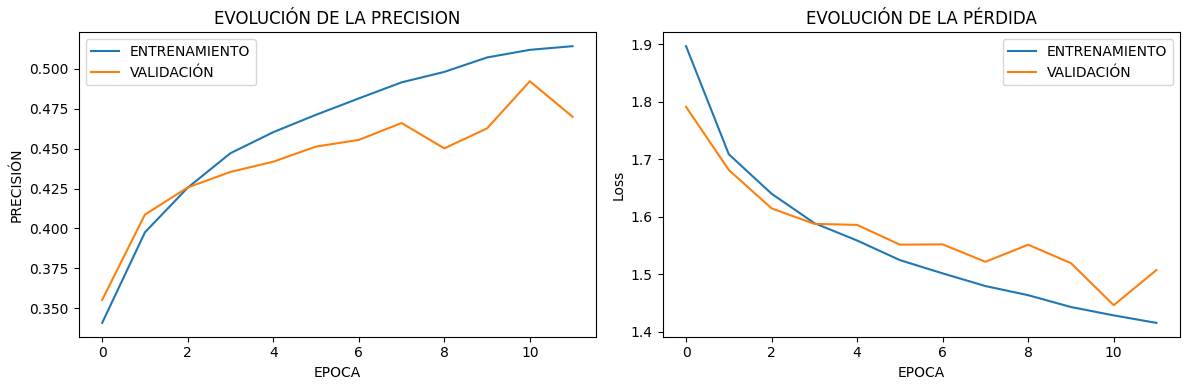

In [16]:
train_accuracy_nuevo = history_nuevo.history['accuracy']
val_accuracy_nuevo =  history_nuevo.history['val_accuracy']
train_loss_nuevo =  history_nuevo.history['loss']
val_loss_nuevo =  history_nuevo.history['val_loss']

# Crear gráficos de precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_nuevo, label='ENTRENAMIENTO')
plt.plot(val_accuracy_nuevo, label='VALIDACIÓN')
plt.xlabel('EPOCA')
plt.ylabel('PRECISIÓN')
plt.title('EVOLUCIÓN DE LA PRECISION')
plt.legend()

# Crear gráficos de pérdida
plt.subplot(1, 2, 2)
plt.plot(train_loss_nuevo, label='ENTRENAMIENTO')
plt.plot(val_loss_nuevo, label='VALIDACIÓN')
plt.xlabel('EPOCA')
plt.ylabel('Loss')
plt.title('EVOLUCIÓN DE LA PÉRDIDA')
plt.legend()

plt.tight_layout()
plt.show()

>**Vemos que pese a que ambos, entrenamiento y validación, están creciendo, la diferencia entre estos es alta, por lo que empieza a haber sobre entreno.**
**Pese a que en este reentreno ‘datagen’ y Learning rate tiene los mismos parámetros que el entreno se ha investigados con diferentes parámetros, sin encontrar mejorias, lo que hace pensar que debido a las diferencias en las fotografías tal vez sea necesario cambiar los parámetros en el modelo.**

## **EVALUACIÓN DEL MODELO CONTRA EL CONJUNTO DE PRUEBAS**

In [17]:
y_pred_nuevas = modelo_cnn_reentreno.predict(X_test_new)
y_pred_classes_nuevas = np.argmax(y_pred_nuevas, axis=1) 



112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


## **CLASSIFICATION REPORT CNN**

In [18]:
class_names = ['Enfado', 'Asco', 'Miedo', 'Felicidad', 'Tristeza', 'Sorpresa', 'Neutral']
print(classification_report(y_test_new, y_pred_classes_nuevas, target_names=class_names))

              precision    recall  f1-score   support

      Enfado       0.44      0.50      0.47       512
        Asco       0.44      0.52      0.48       511
       Miedo       0.41      0.49      0.45       512
   Felicidad       0.83      0.75      0.79       512
    Tristeza       0.51      0.32      0.40       512
    Sorpresa       0.38      0.51      0.43       512
     Neutral       0.76      0.46      0.58       512

    accuracy                           0.51      3583
   macro avg       0.54      0.51      0.51      3583
weighted avg       0.54      0.51      0.51      3583



## **GUARDADO DEL MODELO REENTRENADO**

In [19]:
modelo_cnn_reentreno.save(os.path.join('modelos_entrenados', 'modelo_cnn_reentrenado.h5'))

save_model(modelo_cnn_reentreno, os.path.join('modelos_entrenados', 'modelo_cnnreentrenado.keras'))